# CESM-LE analysis
 - trouble-shooting memory management
 - reading in a large dataset (~10Gb according to xarray)
 - calculations with 36 dask workers from casper tend to spill to disk
 - any suggestions?
 - daniel kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import cftime
import dask
import os

In [2]:
xr.__version__

'0.16.2'

In [3]:
dask.__version__

'2020.12.0'

In [4]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='1:30:00')
cluster.scale(ncores)
client = Client(cluster)

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38813 instead
  http_address["port"], self.http_server.port


In [235]:
#for use on Cheyenne: ONLY RUN THIS CELL ONCE  
### note that you CANNOT access LENS2 from cheyenne
nnodes = 1
ncores = nnodes*36
nmem   = str(int(3*ncores))+'GB'
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300041',
                     queue='premium',
                     resource_spec='select='+str(nnodes)+':ncpus=36:mem=109G',
                     walltime='02:00:00')
cluster.scale(nnodes*36)
client = Client(cluster)

In [5]:
# note that the extra workers can get stuck in the queue
#   rerun this cell until you see that the workers>0
client

Client Scheduler: tcp://10.12.205.30:46405 Dashboard: http://10.12.205.30:38813/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


In [41]:
#client.close()

### functions to find my files

In [6]:
def get_file(ee,model,field,yr):
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
        if yr>2009:
            yy = '.201001-201412.'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+yy+'*')[0]
    return ff

In [7]:
def all_files(model,field,firstyear):
    if model == 'CESM1':
        nens = 42
        files = [get_file(ee,'CESM1',field,0) for ee in range(nens)]
    else:
        nens = 50
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

### Reading the data in:

In [9]:
%%time
model = 'CESM1'
field = 'GPP'
firstyear = 1920
files = all_files(model,field,firstyear)
ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
ensdim.attrs['long_name']='ensemble number'

ds = xr.open_mfdataset(files,combine='nested',concat_dim=ensdim,chunks={'time':24})

CPU times: user 4.38 s, sys: 127 ms, total: 4.51 s
Wall time: 4.45 s


### Adjust time dimension and trim dataset

In [10]:
nmonths = len(ds.time)
yr0 = ds['time.year'][0].values
ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

ix = ds['time.year']>=firstyear
ds = ds.isel(time=ix)

### here's the pertinent data array:

In [11]:
ds.GPP

,Array,Chunk
Bytes,9.59 GB,5.31 MB
Shape,"(42, 1032, 192, 288)","(1, 24, 192, 288)"
Count,17225 Tasks,1806 Chunks
Type,float32,numpy.ndarray


### remove any previous data spills

In [14]:
os.system('rm core-casper*')

0

### sample calculation

In [15]:
%%time
annual_means = ds.GPP.groupby('time.year').mean().compute()

distributed.scheduler - ERROR - Couldn't gather keys {"('transpose-80280a670fa9eda671f612d719f5898f', 7, 24, 0, 0)": [], "('transpose-80280a670fa9eda671f612d719f5898f', 7, 2, 0, 0)": [], "('transpose-80280a670fa9eda671f612d719f5898f', 7, 3, 0, 0)": [], "('transpose-80280a670fa9eda671f612d719f5898f', 7, 25, 0, 0)": []} state: ['processing', 'memory', 'memory', 'processing'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('transpose-80280a670fa9eda671f612d719f5898f', 7, 24, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('transpose-80280a670fa9eda671f612d719f5898f', 7, 2, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('transpose-80280a670fa9eda671f612d719f5898f', 7, 3, 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('transpose-80280a670fa9eda671f612d719f5898f', 7, 25, 0, 0)
NoneType: None


CPU times: user 13.1 s, sys: 2.4 s, total: 15.4 s
Wall time: 16.9 s


### evidence of disk activity

In [16]:
stream = os.popen('ls -lthr core-*')
output = stream.read()
print(output)

-rw------- 1 djk2120 ncar 651M Jan 17 13:44 core-casper31-24189-45947-6
-rw------- 1 djk2120 ncar 693M Jan 17 13:44 core-casper31-24189-45932-6



### calculation did work, despite key gathering thing

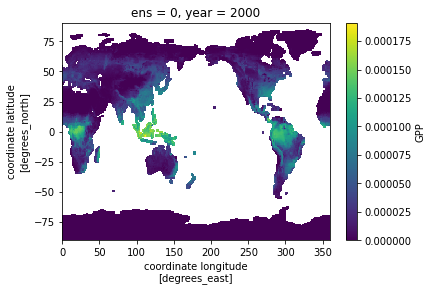

In [21]:
annual_means.sel(ens=0,year=2000).plot();